#### Setup

In [1]:
import numpy as np
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose([transforms.ToTensor()])  # converts images to [0,1] tensors
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data.numpy().astype(np.float32)
y_train = train_dataset.targets.numpy()
X_test  = test_dataset.data.numpy().astype(np.float32)
y_test  = test_dataset.targets.numpy()

X_train_flat = X_train.reshape(len(X_train), -1)  # shape (60000, 784)
X_test_flat  = X_test.reshape(len(X_test), -1)    # shape (10000, 784)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)
print("Data shape:", X_train_scaled.shape, "| Feature mean (approx):", X_train_scaled.mean().round(4))


Data shape: (60000, 784) | Feature mean (approx): -0.0


#### PCA Dimensionality Reduction

In [3]:
from sklearn.decomposition import PCA

# Fit PCA to training data with 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Project the test set into the 2D PCA space
X_test_pca = pca.transform(X_test_scaled)

# PCA attributes
print("PCA mean_ shape:", pca.mean_.shape) 
print("Explained variance:", pca.explained_variance_)
print("Components shape:", pca.components_.shape) 


PCA mean_ shape: (784,)
Explained variance: [40.487637 29.241697]
Components shape: (2, 784)


#### 2D Latent Space

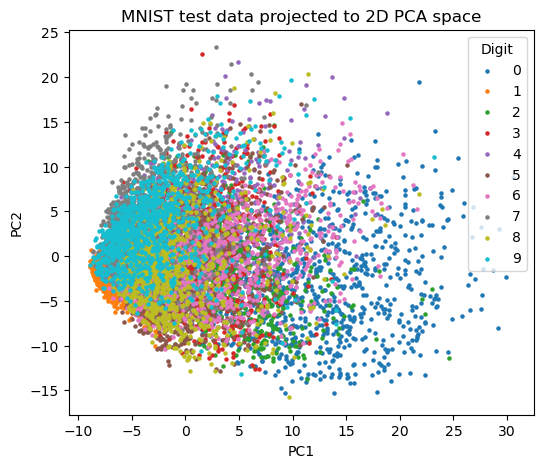

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
# Plot each class in a different color
for digit in range(10):
    mask = (y_test == digit)
    plt.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], s=5, label=str(digit))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MNIST test data projected to 2D PCA space")
plt.legend(title="Digit")
plt.show()


#### Image Reconstruction from PCA

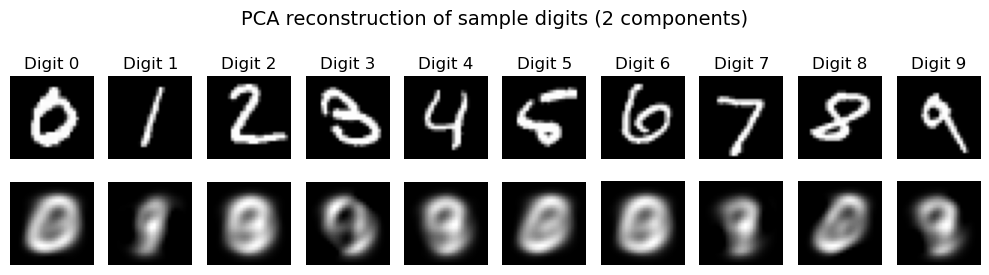

In [5]:
# Select one sample image per digit (0 through 9) from the test set
sample_indices = [np.where(y_test == digit)[0][0] for digit in range(10)]

# Reconstruct those sample images from the 2D PCA latent space
recon_images = []
for idx in sample_indices:
    # Original image (flattened and scaled)
    x_scaled = X_test_scaled[idx].reshape(1, -1)
    # PCA transform to 2D and inverse transform back to scaled 784-d space
    latent = pca.transform(x_scaled)
    x_recon_scaled = pca.inverse_transform(latent)
    # Inverse the scaling to get back to original pixel scale
    x_recon = scaler.inverse_transform(x_recon_scaled).reshape(28, 28)
    recon_images.append(x_recon)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(10, 3))
for i, idx in enumerate(sample_indices):
    # Original image
    axes[0, i].imshow(X_test[idx].reshape(28, 28) / 255.0, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Digit {y_test[idx]}")
    # Reconstructed image (clip values to [0,1] for display)
    axes[1, i].imshow(np.clip(recon_images[i] / 255.0, 0, 1), cmap='gray')
    axes[1, i].axis('off')
# Add row labels
axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Reconstructed", fontsize=12)
plt.suptitle("PCA reconstruction of sample digits (2 components)", fontsize=14)
plt.tight_layout()
plt.show()
